In [35]:
import torch
import tensorflow as tf
import torchvision


import os
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score as accuracy

from tqdm.auto import tqdm

colors = sns.color_palette("rocket")
colors

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [36]:
class Prior_Data_Analys:
  def __init__(self,df):
    self.df = df


  def shape(self):
    n_samples,n_columns = self.df.shape
    print(f'Number of samples in Data Set: {n_samples}')
    print(f'Number of columns: {n_columns}')

    return n_samples,n_columns


  def unique_columns(self):
    columns = self.df.columns
    print(f'Unique columns:\n')

    for column_idx,column in enumerate(columns):
      print(f'Column {column_idx + 1}: {column}')

    return columns


  def columns_dtypes(self):
    dtypes = self.df.dtypes
    print(f'Dtypes:\n\n {dtypes}')

    return dtypes


  def categorical_features(self):
    print(f'Categorical features:\n')
    categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']

    for feature in categorical_feats:
      print(f'* {feature}')

    return np.array(categorical_feats)


  def numerical_features(self):
    print(f'Numerical features: \n')

    numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
    for feature in numerical_feats:
      print(f'* {feature}')

    return np.array(numerical_feats)


  def group_by(self,feature):
    categorical = self.categorical_features()

    if feature in categorical:
      return self.df.groupby([feature]).count()

    else:
      return self.df.groupby([feature]).describe()


  def count_NA(self):
    print(f'Amout of Nans per class:')
    return self.df.isna().sum()


  def duplicates(self):
    print(f'Amount of duplicates: {self.df.duplicated().sum()}')

  def item(self,index):
    print(f'Object number: {index}')

    return self.df.iloc[index]

  def unique_values(self,feature):
    data = self.df[feature]

    values = data.values
    unique_values = np.unique(values)
    print(f'Unique values of {feature}: {unique_values}')

    return unique_values

In [37]:
class Distribution:
  def __init__(self,df,target_feature):
    self.df = df
    self.target_feature = target_feature
    self._eda = Prior_Data_Analys(self.df)


  def distribution_of_target_feature(self):
    for visualization in range(2):
      plt.figure(figsize = (10,10))
      plt.subplot(2,1,visualization + 1)
      if visualization == 0:
        sns.histplot(data = self.df,x = self.target_feature,color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()

      else:
        sns.boxplot(x = self.df[self.target_feature],color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()


  def distribution_of_numerical_features(self):
    numerical_features = self._eda.numerical_features()

    for feature_idx,feature in enumerate(numerical_features):
      plt.figure(figsize = (15,15))
      plt.subplot(len(numerical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.histplot(data = self.df,x = feature,color = colors[1])
      plt.title(f'Distibution of {feature}')
      plt.tight_layout
      plt.show()


  def distribution_of_categorical_features(self,top_k = 5):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      values = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).values[:top_k]
      labels = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).index[:top_k]

      data_dict = {'Labels': labels, 'Values': values}
      data = pd.DataFrame(data_dict)

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.barplot(data = data,y = 'Labels',x = 'Values',color = colors[-1])
      plt.title(f'Top {top_k} {feature} by count')

    plt.tight_layout()
    plt.show()

  def relation_numerical_feats_to_target_feat(self):
    numerical_features = self._eda.numerical_features()

    data = self.df[numerical_features]
    corr = data.corr()

    return sns.heatmap(corr,annot = True, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

  def relation_categorical_feats_to_target_feat(self,top_k = 3):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      feats = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False)[:top_k].index

      data = self.df
      data = data[data[feature].isin(feats)]

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.stripplot(data = data, x = feature, y = self.target_feature,hue = feature)
      plt.title(f'Relation between {feature} (top {top_k}) & {self.target_feature}')

    plt.tight_layout()
    plt.show()

In [38]:
class Image_Df:        
    def _data_from_path(self,path):
        file_names = None
        
        for _, _,filenames in os.walk(path):
            file_names = filenames
            
        labels = [0 if file_name.split('_')[0] == 'notsmoking' else 1 for file_name in file_names]
        
        return np.array(file_names),np.array(labels)

        
    def create_df(self,path):
        images,labels = self._data_from_path(path)
        
        df_dict = {'Image': images, 'Label': labels}
        df = pd.DataFrame(df_dict)
        
        return df

In [39]:
def Image_To_Tensor(image_path,transform,folder_path = None):
    if folder_path != None:
        image = os.path.join(folder_path,image_path)
        image = Image.open(image)
        image = transform(image)
        image = image.permute(1,2,0)
        
        return np.array(image)
    
    else:
        image = Image.open(image_path)
        image = transform(image)
        image = image.permute(1,2,0)
        
        return np.array(image)

In [40]:
class CNN(tf.keras.Model):
    def __init__(self,n_classes):
        super().__init__()
        self.n_classes = n_classes
        
        self.conv_layer_1 = tf.keras.layers.Conv2D(32,3)
        self.conv_layer_2 = tf.keras.layers.Conv2D(32,3)
        self.conv_layer_3 = tf.keras.layers.Conv2D(32,3)
        
        self.max_pool = tf.keras.layers.MaxPool2D(2)
        
        self.relu = tf.keras.layers.ReLU()
        self.softmax = tf.keras.layers.Softmax(1)
        
        self.flatten = tf.keras.layers.Flatten()
        
        self.linear_1 = tf.keras.layers.Dense(128)
        self.linear_2 = tf.keras.layers.Dense(n_classes)
        
    def call(self,X):
        X = self.conv_layer_1(X)
        X = self.relu(X)
        
        X = self.conv_layer_2(X)
        X = self.relu(X)
        X = self.max_pool(X)
        
        X = self.conv_layer_3(X)
        X = self.relu(X)
        X = self.max_pool(X)
        
        X = self.flatten(X)
        
        X = self.linear_1(X)
        X = self.relu(X)
        
        X = self.linear_2(X)
        
        return X

In [41]:
class Train_Model:
    def __init__(self,model,lr = 0.0001,batch_size = 32,epochs = 10):
        self.model = model
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        
    def fit(self,X_train,y_train):
        model = self.model
        
        model.compile(
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr),
            metrics = ['accuracy']
        )
        
        print(f'Metrics on Train Data:')
        model.fit(X_train,y_train,batch_size = self.batch_size,epochs = self.epochs)
        self._fit_model = model
        
        return model
    
    def eval(self,X_test,y_test):
        model = self._fit_model
        
        print(f'\nMetrics on Test Data: ')
        model.evaluate(X_test,y_test)

In [42]:
def Classifie(model,image_path):
    transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (200,200)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    image = Image_To_Tensor(image_path = image_path,transform = transforms)
    image = tf.expand_dims(image,0)
    
    prediction = model(image)
    print(f'Prediction: {prediction}')
    
    label = tf.argmax(prediction,1)
    print(f'Label: {label}')
    
    label_class = 'notsmoking' if np.array(label)[0] == 0 else 'smoking'
    print(f'Class: {label_class}')
    
    return label_class

In [43]:
train_path = '/Users/nazarlenisin/Desktop/Image Classification/Training/Training'
test_path = '/Users/nazarlenisin/Desktop/Image Classification/Testing/Testing'

In [44]:
train_df = Image_Df().create_df(train_path)
test_df = Image_Df().create_df(test_path)
train_df

,Image,Label
0,notsmoking_0098.jpg,0
1,smoking_0143.jpg,1
2,notsmoking_0067.jpg,0
3,smoking_0194.jpg,1
4,smoking_0180.jpg,1
...,...,...
711,smoking_0370.jpg,1
712,smoking_0416.jpg,1
713,notsmoking_0056.jpg,0
714,notsmoking_0042.jpg,0


In [45]:
target_feature = 'Label'

eda = Prior_Data_Analys(train_df)
data_visualization = Distribution(train_df,target_feature = target_feature)

In [46]:
eda.shape()

Number of samples in Data Set: 716
Number of columns: 2


(716, 2)

In [47]:
eda.unique_columns()

Unique columns:

Column 1: Image
Column 2: Label


Index(['Image', 'Label'], dtype='object')

In [48]:
eda.columns_dtypes()

Dtypes:

 Image    object
Label     int64
dtype: object


Image    object
Label     int64
dtype: object

In [49]:
eda.categorical_features()

Categorical features:

* Image


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27846/2509911963.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27846/2509911963.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']


array(['Image'], dtype='<U5')

In [50]:
eda.numerical_features()

Numerical features: 

* Label


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27846/2509911963.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_27846/2509911963.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']


array(['Label'], dtype='<U5')

In [51]:
eda.count_NA()

Amout of Nans per class:


Image    0
Label    0
dtype: int64

In [52]:
eda.duplicates()

Amount of duplicates: 0


In [53]:
eda.unique_values(target_feature)

Unique values of Label: [0 1]


array([0, 1])

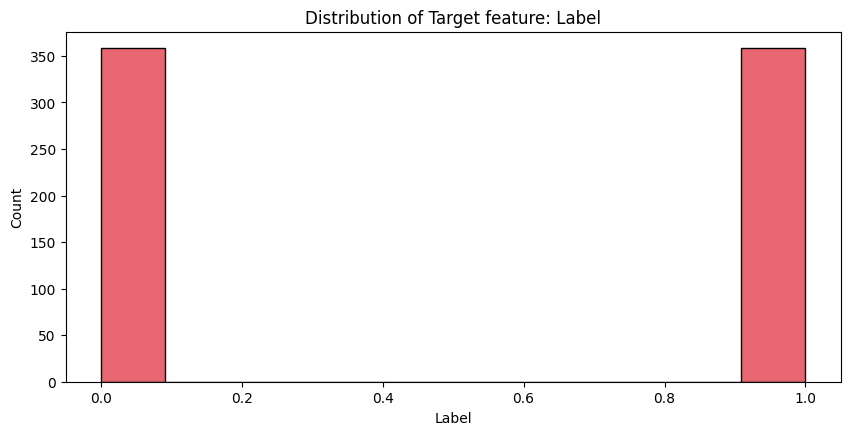

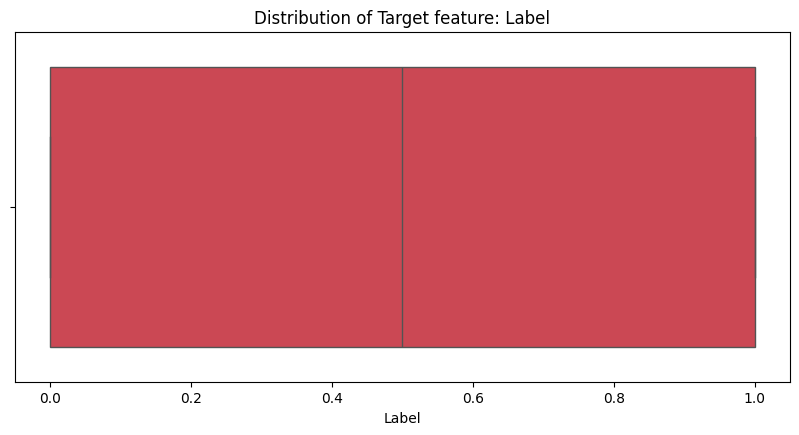

In [54]:
data_visualization.distribution_of_target_feature()

In [55]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (200,200)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


X_train = np.array([Image_To_Tensor(image_path= x,transform= transforms,folder_path= train_path) for x in train_df['Image'].values]) / 255
y_train = train_df['Label'].values

X_test = np.array([Image_To_Tensor(image_path= x,transform= transforms,folder_path= test_path) for x in test_df['Image'].values]) / 255
y_test = test_df['Label'].values

print(f'X train: {X_train.shape}')
print(f'y train: {y_train.shape}')

print(f'\nX test: {X_test.shape}')
print(f'y test: {y_test.shape}')

X train: (716, 200, 200, 3)
y train: (716,)

X test: (224, 200, 200, 3)
y test: (224,)


In [56]:
n_classes = len(eda.unique_values(target_feature))
model = CNN(n_classes)

Trainer = Train_Model(model,epochs = 30)

model = Trainer.fit(X_train,y_train)
Trainer.eval(X_test,y_test)

Unique values of Label: [0 1]
Metrics on Train Data:
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5866 - loss: 0.6784
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6992 - loss: 0.5836
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7270 - loss: 0.5453
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7603 - loss: 0.5356
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7332 - loss: 0.5337
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7681 - loss: 0.5184
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7564 - loss: 0.5103
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7648 - loss: 0.5015
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7716 - loss: 0.5102
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7777 - loss: 0.4936
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7734 - loss: 0.4986
Epoch 12/30
23/23 ━━━

Prediction: [[-47.448757  89.05742 ]]
Label: [1]
Class: smoking
Person on image: smoking


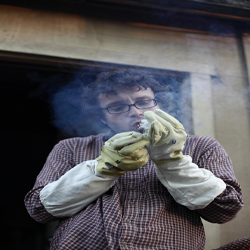

In [57]:
image_path = '/Users/nazarlenisin/Desktop/Image Classification/Testing/Testing/smoking_0506.jpg'

image_class = Classifie(model,image_path)

print(f'Person on image: {image_class}')
Image.open(image_path)
